In [1]:
from pyalgotrade import barfeed
from pyalgotrade import bar

# Example BarFeed for dataframes with data for a single instrument.
class DataFrameBarFeed(barfeed.BaseBarFeed):
    def __init__(self, dataframe, instrument, frequency):
        super(DataFrameBarFeed, self).__init__(frequency)
        self.registerInstrument(instrument)
        self.__df = dataframe
        self.__instrument = instrument
        self.__next = 0

    def reset(self):
        super(DataFrameBarFeed, self).reset()
        self.__next = 0

    def peekDateTime(self):
        return self.getCurrentDateTime()

    def getCurrentDateTime(self):
        ret = None
        if not self.eof():
            rowkey = self.__df.index[self.__next]
            ret = rowkey.to_datetime()
        return ret

    def barsHaveAdjClose(self):
        return True

    def getNextBars(self):
        ret = None
        if not self.eof():
            # Convert the dataframe row into a bar.BasicBar
            rowkey = self.__df.index[self.__next]
            row = self.__df.ix[rowkey]
            bar_dict = {
                self.__instrument: bar.BasicBar(
                    rowkey.to_datetime(),
                    row["Open"],
                    row["High"],
                    row["Low"],
                    row["Close"],
                    row["Volume"],
                    row["Adj Close"],
                    self.getFrequency()
                )
            }
            ret = bar.Bars(bar_dict)
            self.__next += 1
        return ret

    def eof(self):
        return self.__next >= len(self.__df.index)

    def start(self):
        pass

    def stop(self):
        pass

    def join(self):
        pass


In [11]:
import datetime
import pandas as pd
import zipfile
import urllib2
from pyalgotrade import strategy
from pyalgotrade.feed import csvfeed
from pyalgotrade import barfeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 1000000)
        self.__position = None
        self.__instrument = instrument
        # We'll use adjusted close values instead of regular close values.
        self.__sma = ma.EMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None
    
    def getSMA(self):
        return self.__sma
    
    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at $%.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate a SMA.
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                # Enter a buy market order for 10 shares. The order is good till canceled.
                NoShares = 0.8*self.getBroker().getCash()/bar.getPrice() -1
                self.__position = self.enterLong(self.__instrument, NoShares, True)
        # Check if we have to exit the position.
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()


def run_strategy(smaPeriod,feed,Ticker):
    # Load the yahoo feed from the CSV file
    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, Ticker, smaPeriod)
    returnsAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(returnsAnalyzer)
    #plt = plotter.StrategyPlotter(myStrategy)
    #plt.getInstrumentSubplot("DBC").addDataSeries("SMA", myStrategy.getSMA())    
    #plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())
    myStrategy.run()
    print( "Final portfolio value: $%.2f", myStrategy.getBroker().getEquity())
    return( myStrategy.getBroker().getEquity())
    #plt.plot()
    
def run_strategy_withGraph(smaPeriod,feed,Ticker):
    # Load the yahoo feed from the CSV file
    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, Ticker, smaPeriod)
    returnsAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(returnsAnalyzer)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getInstrumentSubplot(Ticker).addDataSeries("SMA", myStrategy.getSMA())    
    plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())
    myStrategy.run()
    print( "Final portfolio value: $%.2f", myStrategy.getBroker().getEquity())
    plt.plot()    
    return( myStrategy.getBroker().getEquity())
def getData(date):
    link = 'http://images1.cafef.vn/data/'+date.strftime('%Y%m%d') + \
    '/CafeF.SolieuGD.Upto'+date.strftime('%d%m%Y') +'.zip'
    #'http://images1.cafef.vn/data/20170303/CafeF.SolieuGD.03032017.zip'
    #http://images1.cafef.vn/data/20170303/CafeF.SolieuGD.Upto03032017.zip
    fileName = 'D:\\python\\vnstock\\history.zip'
    req = urllib2.urlopen(link)
    file = open(fileName, 'wb')
    file.write(req.read())
    file.close()
    exchanges = ['HSX','HNX']
    list_ =[]
    with zipfile.ZipFile(fileName) as myzip:
        for exchange in exchanges:
            with myzip.open('CafeF.'+exchange+'.Upto'+date.strftime('%d.%m.%Y')+'.csv') as myfile:
                data = pd.read_csv(myfile, header = 0,names = ['Ticker','Date','Open','High','Low','Close','Volume'])
                list_.append(data)
    frame = pd.concat(list_)
    frame['Date'] = pd.to_datetime(frame.Date, format='%Y%m%d')
    return(frame)

def pivotData(data):
    pivotedData = data.drop_duplicates(subset =['Date','Ticker'])
    pivotedData = pivotedData.pivot(index='Date',columns = 'Ticker',values ='Close')
    pivotedData.to_csv('D:\\python\\vnstock\\pivotedData.csv')

In [13]:
data = getData(datetime.datetime(2017,3,31,0,0))


In [14]:
print data

          Ticker       Date       Open       High        Low      Close  \
0         VNXALL 2017-03-31  1054.0000  1057.6500  1052.7700  1053.1700   
1       FUCVREIT 2017-03-31    24.4500    24.4500    24.4500    24.4500   
2            VNA 2017-03-31     0.9400     1.0100     0.9400     0.9800   
3            VNE 2017-03-31     8.8900     9.1000     8.8900     9.1000   
4            VNG 2017-03-31    11.3000    11.3000    10.8000    10.8000   
5            VNL 2017-03-31    24.5000    24.5000    24.5000    24.5000   
6            VNM 2017-03-31   144.7000   145.1000   143.3000   143.3000   
7            VNS 2017-03-31    28.5000    28.5000    27.8000    28.2500   
8            VOS 2017-03-31     1.1500     1.1500     1.1200     1.1300   
9            VPH 2017-03-31    11.4000    11.7000    10.9500    11.4000   
10           VPK 2017-03-31    13.0000    13.7000    13.0000    13.2000   
11           VPS 2017-03-31    20.2000    20.5000    20.2000    20.5000   
12           VRC 2017-03-

In [5]:
data = data.drop_duplicates(subset = ['Date','Ticker'])
dbc = data[data.Ticker == "DBC"]
dbc.reset_index()
print(dbc)

       Ticker       Date     Open     High      Low    Close  Volume
38        DBC 2017-03-10  33.8000  34.2000  33.7000  34.2000  162812
310       DBC 2017-03-09  34.6000  34.6000  33.6000  33.8000   27621
572       DBC 2017-03-08  34.0000  34.7000  33.6000  34.1000  215628
838       DBC 2017-03-07  33.7000  34.0000  33.6000  34.0000   40500
1097      DBC 2017-03-06  34.0000  34.0000  33.7000  33.7000   24540
1372      DBC 2017-03-03  33.2000  34.5000  33.2000  34.0000  458949
1638      DBC 2017-03-02  33.4000  33.5000  33.2000  33.3000   39910
1908      DBC 2017-03-01  33.6000  33.9000  33.3000  33.4000   43300
2185      DBC 2017-02-28  33.3000  34.2000  33.3000  33.6000  258579
2469      DBC 2017-02-27  34.0000  34.0000  33.3000  33.5000   78120
2745      DBC 2017-02-24  33.8000  34.0000  33.2000  34.0000  156999
3022      DBC 2017-02-23  34.1000  34.5000  33.8000  33.8000  186318
3302      DBC 2017-02-22  34.8000  35.0000  34.2000  34.2000  124491
3571      DBC 2017-02-21  34.9000 

In [6]:
dbc.set_index("Date", inplace = True)


In [7]:
print dbc

           Ticker     Open     High      Low    Close  Volume
Date                                                         
2017-03-10    DBC  33.8000  34.2000  33.7000  34.2000  162812
2017-03-09    DBC  34.6000  34.6000  33.6000  33.8000   27621
2017-03-08    DBC  34.0000  34.7000  33.6000  34.1000  215628
2017-03-07    DBC  33.7000  34.0000  33.6000  34.0000   40500
2017-03-06    DBC  34.0000  34.0000  33.7000  33.7000   24540
2017-03-03    DBC  33.2000  34.5000  33.2000  34.0000  458949
2017-03-02    DBC  33.4000  33.5000  33.2000  33.3000   39910
2017-03-01    DBC  33.6000  33.9000  33.3000  33.4000   43300
2017-02-28    DBC  33.3000  34.2000  33.3000  33.6000  258579
2017-02-27    DBC  34.0000  34.0000  33.3000  33.5000   78120
2017-02-24    DBC  33.8000  34.0000  33.2000  34.0000  156999
2017-02-23    DBC  34.1000  34.5000  33.8000  33.8000  186318
2017-02-22    DBC  34.8000  35.0000  34.2000  34.2000  124491
2017-02-21    DBC  34.9000  35.3000  34.6000  34.9000  232884
2017-02-

C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\

Running for PDR

('Final portfolio value: $%.2f', 1230821.1653999998)


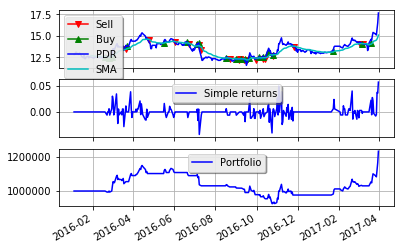

In [17]:
data = data.drop_duplicates(subset = ['Date','Ticker'])
results = pd.DataFrame(columns=('Ticker','PnL','Start','End'))
for Ticker in ['PDR']:
    ss = data[data.Ticker == Ticker]
    ss['Adj Close'] = ss['Close']
    ss.set_index("Date", inplace = True)
    ss.sort_index(inplace = True)      
    ss2015 = ss.loc[ss.index > datetime.datetime(2016,1,1,0,0)]
    condition = ss2015.High < ss2015.Close
    ss2015.High[condition] = ss2015.Close[condition]
    condition = ss2015.High < ss2015.Open
    ss2015.High[condition] = ss2015.Open[condition]  
    condition = ss2015.Low > ss2015.Close
    ss2015.Low[condition] = ss2015.Close[condition]  
    condition = ss2015.Low > ss2015.Open
    ss2015.Low[condition] = ss2015.Open[condition]     
    feed = DataFrameBarFeed(ss2015,Ticker, barfeed.Frequency.DAY)
    print("Running for " + Ticker + "\n")
    PnL = run_strategy_withGraph(20,feed,Ticker)
    Start_Price = ss2015['Close'][0]
    End_Price = ss2015.Close[-1]
    tempDF = pd.DataFrame({'Ticker':[Ticker],'PnL':[(PnL-1000000)/1000000], 'Start':[Start_Price],'End':[End_Price]})
    results = pd.concat([results,tempDF])
plt.show()    

In [11]:
from IPython.display import display, HTML
results['YoY Change']= results['End'] - results['Start']
results['Pct YoY Change'] = results['YoY Change']/results['Start']
results = results.sort(["PnL"])
HTML(results.to_html())
results.to_csv('summary.csv')

C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


IOError: [Errno 13] Permission denied: 'summary.csv'

In [9]:
Tickers =['VCB',\
'VIC',\
'GAS',\
'CTG',\
'ROS',\
'BID',\
'MSN',\
'BVH',\
'HPG',\
'MWG',\
'MBB',\
'ACB',\
'FPT',\
'STB',\
'CTD',\
'EIB',\
'SSI',\
'VCS',\
'DHG',\
'DPM',\
'HSG',\
'NT2',\
'PVD',\
'BMP',\
'CII',\
'PVS',\
'REE',\
'KDC',\
'HT1',\
'PNJ',\
'VCG',\
'KBC',\
'HNG',\
'SBT',\
'GMD',\
'HAG',\
'TCH',\
'LGC',\
'DCM',\
'SHB',\
'PVI',\
'PHP',\
'GTN',\
'NTP',\
'PPC',\
'KDH',\
'HBC',\
'FLC',\
'BIC',\
'VCF',\
'VHC',\
'PAN',\
'DXG',\
'TRA',\
'HCM',\
'ITA',\
'TLG',\
'DRC',\
'PVT',\
'PGD',\
'ASM',\
'VSH',\
'CAV',\
'NLG',\
'POM',\
'VNR',\
'PDR',\
'DVP',\
'CHP',\
'PTB',\
'VSC',\
'DMC',\
'SKG',\
'DBC',\
'SJS',\
'BMI',\
'NKG',\
'PLC',\
'PHR',\
'IJC',\
'NCT',\
'IMP',\
'PTI',\
]

In [16]:
%matplotlib
import matplotlib.pyplot as pl;t
stb = data[data.Ticker == 'DBC']
stb['ewa'] = pd.rolling_mean(stb['Close'],20)
stb = stb.set_index(['Date'])
stb = stb.loc[stb.index > datetime.datetime(2016,1,1,0,0)]
stb = stb.sort_index()
plt.figure(50)
stb.plot(y = ['Close','ewa'],grid = True)


Using matplotlib backend: Qt5Agg


C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
